In [1]:
# !pip install pyAgrum
# !pip install pydotplus

import glob
import pickle
import pandas as pd
import numpy as np
# import bnlearn as bn
import pickle
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
from tqdm import tqdm
import random
from random import randint
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn. model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import networkx as nx
import math
import pyAgrum.causal as cls

In [2]:
# files =  ['asia_ccdr','asia_lingam', 'asia_notears', 'asia_nobears']
thresh = 0.5



In [3]:
##helper funcs
# def save_bool(dataset_name, replace, vals,noisy=False):
#     if noisy==False:
#         df = pd.read_csv(f"Datasets/{dataset_name}.csv")
#         df = df.replace(to_replace = replace ,value = vals)
#         df.to_csv(f"Datasets/{dataset_name}_bool.csv")
#     else:
#         df = pd.read_csv(f"Noisy_Datasets/{dataset_name}.csv")
#         df = df.replace(to_replace = replace ,value = vals)
#         df.to_csv(f"Noisy_Datasets/{dataset_name}_bool.csv")
    
def random_exclude(df, exclude):
#     print(exclude)
    exclude = set(exclude)
    randInt = randint(0, len(df.columns)-1)
    while randInt in exclude:
        randInt = randint(0, len(df.columns)-1) 
    if randInt in exclude:
        print(randInt)
    return randInt 

In [4]:
def get_adjmats(dataset_name):
    fpaths = (glob.glob(f"adj_mats/{dataset_name}*.csv")) 
    fnames = [i.split('/')[-1].split('.')[0] for i in fpaths]
    return fnames

In [18]:

def get_nodnames(dataset_name):
    df = pd.read_csv(f"../Datasets/{dataset_name}.csv")
    nod_names = list(df.columns)
    return nod_names

In [6]:
def add_noise(dataset_name,num_disc,p_entry=0.1,p_node=0.3):
    df = pd.read_csv(f"Datasets/{dataset_name}.csv")
    for i in range(df.shape[0]):
#         1/p_entry if p_entry!=0 else  
        r1 = random.random()
        #First Decide if u want that row or not
        if r1<=p_entry:
            #Now for this entry make a node array
            rand_nodes_array=np.random.rand(df.shape[1])
            rand_nodes_array_boolean = rand_nodes_array<p_node
            if num_disc==2:
                for j in range(len(rand_nodes_array_boolean)):
                    if rand_nodes_array_boolean[j]==True:
                        1 if df.iloc[i][j]==0 else 0
            if num_disc==3:
                for j in range(len(rand_nodes_array_boolean)):
                    if rand_nodes_array_boolean[j]==True:
                        nod_dic={0:[1,2],1:[0,2],2:[0,1]}
                        rand_value=random.random()
                        if rand_value<0.5:
                            df.iloc[i][j]= nod_dic[df.iloc[i][j]][0]
                        else:
                            df.iloc[i][j]= nod_dic[df.iloc[i][j]][1]
    
    df.to_csv(f"Noisy_Datasets/{dataset_name}.csv")
    return df
                    


In [7]:
def build_bns(fnames, nod_names, num_disc, drop_nodes=[], dropped=False,noisy=False):  

    learned_bns = {}
    Graphs = {}
    
    for fname in fnames :
        try:
            bn = gum.BayesNet(fname)
            if dropped:
                df = pd.read_csv(f"adj_mats/dropped_{fname}.csv")
            else:
                df = pd.read_csv(f"adj_mats/{fname}.csv")
            df = df.reset_index()
            df = df[list(df.columns[1:])]
            df = df.set_index(df.columns[0])
            dict_ = df.to_dict()
                
            adj_mat = {}
            for n1 in dict_:
                adj_mat[n1] = {}
                for n2 in dict_[n1]:
                    if dict_[n1][n2] >=thresh:
                        adj_mat[n1][n2] =1
                    elif dict_[n1][n2] <=-thresh:
                        adj_mat[n1][n2] =-1
                    else:
                        adj_mat[n1][n2] = 0
                                  
            nod_names = list(adj_mat.keys()) 
            dataset_name = fname.split('_')[0]
            data = pd.read_csv(f"Datasets/{dataset_name}.csv")

            variables = [ bn.add(name, len(pd.unique(data[name]))) for name in nod_names]

            G = nx.DiGraph()
            for i in nod_names:
                G.add_node(i)
                
            for i in adj_mat:
                for j in adj_mat[i]:
                    if adj_mat[i][j]==1:
                        bn.addArc(i, j)
                        G.add_edge(i, j)
                    elif adj_mat[i][j]==-1:
                        bn.addArc(j, i)
                        G.add_edge(j, i)
                        
            if dropped:
                plt.savefig(f"networkx/dropped_{fname}.png", dpi=300, bbox_inches='tight')
                nx.write_gexf(G,f"networkx/dropped_{fname}.gexf")
            else:
                nx.draw(G, with_labels=True)
                plt.show()
                plt.savefig(f"networkx/{fname}.png", dpi=300, bbox_inches='tight')
                nx.write_gexf(G,f"networkx/{fname}.gexf")
            
            if dropped:
                df = pd.read_csv(f"Datasets/{dataset_name}.csv")
                for i in drop_nodes:
                    df.drop(nod_names[i], axis = 1)
                df.to_csv(f"temp/{dataset_name}_dropped.csv")
                learner=gum.BNLearner(f"temp/{dataset_name}_dropped.csv",  bn) #using bn as template for variables and labels
                learner.useAprioriSmoothing(1000) 
                bn2=learner.learnParameters(bn.dag())
                learned_bns[fname] = bn2
            if noisy:
                learner=gum.BNLearner(f"Noisy_Datasets/{dataset_name}.csv",  bn) #using bn as template for variables and labels
                learner.useAprioriSmoothing(1000) 
                bn2=learner.learnParameters(bn.dag())
                learned_bns[fname] = bn2
            else:
                learner=gum.BNLearner(f"Datasets/{dataset_name}.csv",  bn) #using bn as template for variables and labels
                learner.useAprioriSmoothing(1000) 
                bn2=learner.learnParameters(bn.dag())
                learned_bns[fname] = bn2
            Graphs[fname] = G
        except:
            continue
    return learned_bns, Graphs

In [20]:
def generate_queries(dataset_name, drop_nodes = [],noisy=False):
    df = pd.read_csv(f"../Datasets/{dataset_name}_bool.csv") if noisy==False else pd.read_csv(f"../Noisy_Datasets/{dataset_name}.csv")
    num_queries = 500

    queries = set([])
    for i in tqdm(range(num_queries)):

        q0_ind = random_exclude(df, drop_nodes) 
        q0 = df.columns[q0_ind]
        do_ind = random_exclude(df, drop_nodes+[q0_ind]) 
        do = df.columns[do_ind]
        evidence_ind = random_exclude(df, drop_nodes+[q0_ind, do_ind]) 
        evidence = df.columns[evidence_ind]
        do_val = df.sample()[do].values[0]
        evidence_val = df.sample()[evidence].values[0]
        query = ((q0, do, do_val, evidence, evidence_val))
        queries.add(query)
    return queries

In [22]:
def true_probs(dataset_name, queries):
    bn=gum.loadBN(f"../Datasets/{dataset_name}.bif")
    model = cls.CausalModel(bn)

    
    y_true = []
    for q in queries:
        opt = cls.doCalculusWithObservation(cm=model, on=set([q[0]]), doing = set([q[1]]), knowing=set([q[3]]) )
        opt = opt.eval().toarray()
        if len(opt.shape)==3:
            y_true.append(opt[0][0][0])
        elif len(opt.shape)==2:
            y_true.append(opt[0][0])
        else:
            y_true.append(opt[0])
    return y_true




In [10]:
def helper(var, val, df_num, df_bool):
    d=dict(zip(df_bool[var].unique(),df_num[var].unique()))
    return d[val]

def get_prob_models(files, queries, drop_nodes=[]):
    df_num = pd.read_csv(f"Datasets/{dataset_name}.csv") 
    df_bool = pd.read_csv(f"Datasets/{dataset_name}_bool.csv") 
    y_models = {}
    for k in tqdm(files):

        y_models[k] = []
        bn = learned_bns[k]
        model = cls.CausalModel(bn)
        for q in (queries):
            if nod_names.index(q[0]) not in drop_nodes and nod_names.index(q[1]) not in drop_nodes and nod_names.index(q[3]) not in drop_nodes:
                val_do = helper(q[1], q[2], df_num, df_bool)
                val_ev = helper(q[3], q[4], df_num, df_bool)

                opt = cls.doCalculusWithObservation(cm=model, on=set([q[0]]), doing = set([q[1]]), knowing=set([q[3]]) )
#                 opt = cls.causalImpact(cm=model, on=q[0], doing = q[1], knowing=set([q[3]]), values={q[1]: val_do, q[3]: val_ev } )
                opt = opt.eval().toarray()
                if len(opt.shape)==3:
                    ans = (opt[0][0][0])
                elif len(opt.shape)==2:
                    ans = (opt[0][0])
                else:
                    ans = (opt[0])
                y_models[k].append(ans)
                
    return y_models

In [11]:
def fix_adjmats(learned_bns, files, dropped=False):
    learned_bns.keys()
    adjs = {}
    for file in files:
        df = pd.read_csv(f"adj_mats/{file}.csv")
        df = df.reset_index()
        df = df[list(df.columns[2:])]
        adj = df.to_numpy()
        adj[adj >= thresh] = 1
        indices = np.where(adj <= -thresh)
        adj[adj < 0] = 0
        indices = indices[::-1]
        adj[indices]=1
        adjs[file.split('/')[-1]] = (adj.reshape(-1,1))

    return adjs

In [12]:
def eval_binary(nod_names, files, queries, adjs, y_true):
    p_models = {}
  
    X = []
    y = []
    n=nod_names
    queries = list(queries)
    for i in range(len(queries)):

        for model in files:
            adj = adjs[model] 
            merged = list(itertools.chain.from_iterable(adj.tolist()))
            q = [n.index(queries[i][0]), n.index(queries[i][1])]

            X.append(merged+(q))
            diff= abs(y_models[model][i]-y_true[i])
            value = 1 if diff < 0.20 else 0
            y.append(value)
    clf = RandomForestClassifier(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf.fit(X_train, y_train)
    y_pred = (clf.predict(X_test))
    y_prob= clf.predict_proba(X_test)
    y_prob=y_prob[:, 1]

    print(accuracy_score(y_test, y_pred))



In [13]:
def prepare_data(fnames):
    for fname in fnames:
        bn=gum.loadBN(f"Datasets/{fname}.bif") 
        d = gum.BNDatabaseGenerator(bn)
        gum.generateCSV(bn, f"Datasets/{fname}_bool.csv", 50000, with_labels=True)
        df = pd.read_csv(f"Datasets/{fname}_bool.csv")
        for c in df.columns:
            df[c] = df[c].astype('category')
            df[c] = df[c].cat.codes
#         df = df[df.columns[1:]]
        df.to_csv(f"Datasets/{fname}.csv", index=False)
        print(fname)

In [14]:
# prepare_data(['andes', 'diabetes', 'alarm'])
# prepare_data(['asia', 'sachs'])

## Binary Classification

In [21]:

dataset_name = 'asia'
num_disc = 2
fnames = get_adjmats(dataset_name)
nod_names = get_nodnames(dataset_name)
learned_bns, Graphs = build_bns(fnames, nod_names, num_disc)
files = list(learned_bns.keys())
queries = generate_queries(dataset_name)
y_true = true_probs(dataset_name, queries)
y_models = get_prob_models(files, queries)
adjs = fix_adjmats(learned_bns, files)


100%|████████████████████████████████████████| 500/500 [00:03<00:00, 162.67it/s]


IOError: [pyAgrum] I/O Error: No such file Datasets/asia.bif

In [19]:
learned_bns, Graphs 

({'asia_nobears': (pyAgrum.BayesNet<double>@0x5555c6467b30) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 48},
  'asia_ccdr': (pyAgrum.BayesNet<double>@0x5555c648ea60) BN{nodes: 8, arcs: 5, domainSize: 256, dim: 28},
  'asia_lingam': (pyAgrum.BayesNet<double>@0x5555c651bd40) BN{nodes: 8, arcs: 5, domainSize: 256, dim: 34},
  'asia_notears': (pyAgrum.BayesNet<double>@0x5555c6503440) BN{nodes: 8, arcs: 4, domainSize: 256, dim: 24}},
 {'asia_nobears': <networkx.classes.digraph.DiGraph at 0x7f4ff891fee0>,
  'asia_ccdr': <networkx.classes.digraph.DiGraph at 0x7f4ff891f6a0>,
  'asia_lingam': <networkx.classes.digraph.DiGraph at 0x7f4ff891f8b0>,
  'asia_notears': <networkx.classes.digraph.DiGraph at 0x7f4f750a93d0>})

In [20]:
eval_binary(nod_names, files, queries, adjs, y_true)

0.8191489361702128


In [21]:
nod_names

['smoke', 'tub', 'bronc', 'asia', 'lung', 'xray', 'dysp', 'either']

# BN Classification 

In [15]:
"""bn = gum.BayesNet("Surviving Titanic")
bn =gum.fastBN("Age{baby|toddler|kid|teen|adult|old}<-Survived{False|True}->Gender{Female|Male};Siblings{False|True}<-Survived->Parents{False|True}")
print(bn.variable("Survived"))
print(bn.variable("Age"))
print(bn.variable("Gender"))
print(bn.variable("Siblings"))
print(bn.variable("Parents"))

bn

learner = gum.BNLearner("res/titanic/post_train.csv", bn)
bn = learner.learnParameters(bn.dag())
gnb.showInference(bn, size="10")

showROC_PR(bn, "res/titanic/post_train.csv", 'Survived', "True", True, True)

ie = gum.LazyPropagation(bn)
init_belief(ie)
ie.addTarget('Survived')
result = testdf.apply(lambda x: is_well_predicted(ie, bn, 0.35917266477065596, x), axis=1)
result.value_counts(True)


""""


Survived:Labelized(<False,True>)
Age:Labelized(<baby,toddler,kid,teen,adult,old>)
Gender:Labelized(<Female,Male>)
Siblings:Labelized(<False,True>)
Parents:Labelized(<False,True>)


InvocationException: GraphViz's executables not found

(pyAgrum.BayesNet<double>@0x55b786a44780) BN{nodes: 5, arcs: 4, domainSize: 96, dim: 26}


## Multiclass Classification

In [16]:
def multiclass(nod_names, files, queries, adjs, y_true, Graphs, dropped_nodes=[]):
    p_models = {}

    X = []
    y = []
    q_edge_length = []
    q_deg_centrality = {'target': [], 'evs':[]}
    q_betw_centrality = {'target': [], 'evs':[]}
    

    # n = list(df.columns)
    model_to_int = {}
    # model to int mapping
    for ind in range(len(files)):
        model_to_int[files[ind]] = ind
    n=nod_names
    queries = list(queries)
    diff_array=[[] for i in range(len(files))]
    for i in range(len(queries)):
        q = queries[i]
        if q[0] not in dropped_nodes and q[1] not in dropped_nodes:
            m, min_diff = "", 1000000 
            count=0
            if y_models[list(y_models.keys())[0]][i] != None:
                for model in files:
#                     print()
                    if y_models[model][i] != None:
                        diff = abs(y_models[model][i]-y_true[i])
                        diff_array[count].append(diff)
                    count+=1
                    if diff < min_diff:
                        min_diff = diff
                        m = model
                G = Graphs[model]        

        #         dpath = {x[0]:x[1] for x in path}
        #         print(m, dpath)
                deg_centrality = nx.degree_centrality(G)
                betw_centrality= nx.betweenness_centrality(G)

        #         q_edge_length.append(dpath[q[0]][q[1]])
        #         print(G.nodes)
        #         print(q)
                if q[0] in G.nodes and q[1] in G.nodes and (nx.has_path(G, q[0], q[1])):
                    path = nx.shortest_path_length(G, q[0], q[1])
                    q_edge_length.append(path)
 
                else:
                    q_edge_length.append(math.inf)


                q_deg_centrality['target'].append(deg_centrality[q[0]])
                q_betw_centrality['target'].append(betw_centrality[q[0]])
                q_deg_centrality['evs'].append(deg_centrality[q[1]])
                q_betw_centrality['evs'].append(betw_centrality[q[1]])
                q = [n.index(queries[i][0]), n.index(queries[i][1])]
                X.append(q)
                y.append(model_to_int[m])
    print(model_to_int)

    clf = RandomForestClassifier(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = (clf.predict(X_test))
    y_prob= clf.predict_proba(X_test)
    y_prob=y_prob[:, 1]
    acc = accuracy_score(y_test, y_pred)
    print(acc)
    df = pd.DataFrame({'Query': X , 'Label': y, 'Edge Lengths': q_edge_length, 
                       'degree_centrality_target': q_deg_centrality['target'], 'degree_centrality_evs':  q_deg_centrality['evs'],
                      'betweeness_centrality_target': q_betw_centrality['target'], 'betweeness_centrality_evs':  q_betw_centrality['evs']})
    for i in range(len(files)):
        col_name='Model_'+str(i)
        df[col_name]=diff_array[i]

    return df, clf, acc
        
        

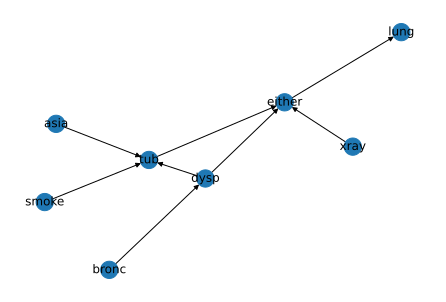

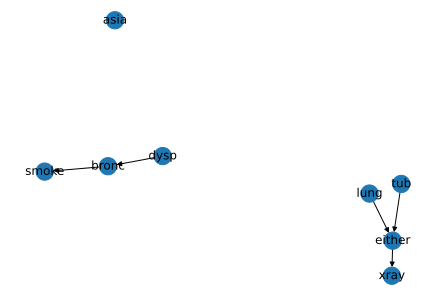

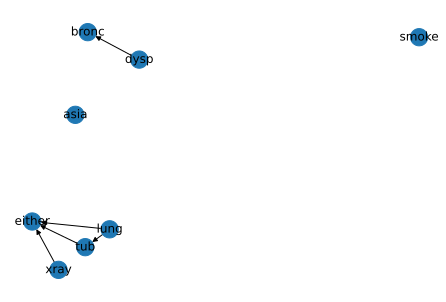

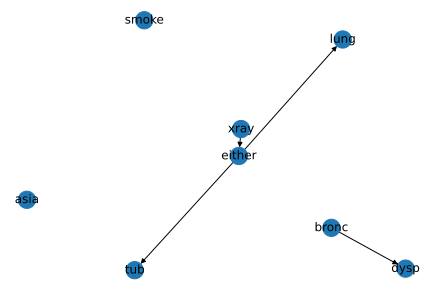

100%|████████████████████████████████████████| 500/500 [00:02<00:00, 177.90it/s]


yture


100%|█████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]


ymodels
Adjs
{'asia_nobears': 0, 'asia_ccdr': 1, 'asia_lingam': 2, 'asia_notears': 3}
0.7352941176470589


<Figure size 432x288 with 0 Axes>

In [26]:
dataset_name = 'asia'
fnames = get_adjmats(dataset_name)
nod_names = get_nodnames(dataset_name)
learned_bns, Graphs = build_bns(fnames, nod_names, 4)
files = list(learned_bns.keys())
queries = generate_queries(dataset_name)
y_true = true_probs(dataset_name, queries)
y_models = get_prob_models(files, queries)
adjs = fix_adjmats(learned_bns, files)
df, clf, acc = multiclass(nod_names, files, queries, adjs, y_true, Graphs)

## Analysis

In [116]:
import pyAgrum.causal

In [26]:
# !pip install plotly

# import plotly.express as px

In [117]:
model_to_int={'asia_nobears': 0, 'asia_ccdr': 1, 'asia_lingam': 2, 'asia_notears': 3}
# model_to_int={'sachs_ccdr': 0, 'sachs_lingam': 1, 'sachs_dagGNN': 2, 'sachs_notears': 3}

# model_to_int = {y:x for x,y in model_to_int.iteritems()}

my_dict = { model_to_int[k]:k for k in model_to_int}

df["Model_name"]=df["Label"]
df["Model_name"].replace(my_dict, inplace=True)
df["Edge Lengths"].replace({math.inf: 0}, inplace=True)

In [118]:
df.columns

Index(['Query', 'Label', 'Edge Lengths', 'degree_centrality_target',
       'degree_centrality_evs', 'betweeness_centrality_target',
       'betweeness_centrality_evs', 'Model_0', 'Model_1', 'Model_2', 'Model_3',
       'Model_name'],
      dtype='object')

In [123]:
fig = px.histogram(df, x="Model_3", histnorm="percent", nbins=30)
# fig.update_layout(yaxis_range=[0, 1])
fig.update_layout(
    
    title_text=f'Absolute difference histogram for asia_notears', # title of plot
    bargap=0.01

)
fig.update_xaxes(nticks=30)
fig.show()

In [135]:
# model_to_int={'asia_nobears': 0, 'asia_ccdr': 1, 'asia_lingam': 2, 'asia_notears': 3}

fig = px.scatter(df.sort_values(by=['Edge Lengths']), y="Model_3", x= "Edge Lengths")
fig.update_layout(yaxis_range=[0, 1])
fig.update_layout(
    
    title_text=f'Edge Lengths vs Absolute difference for asia_notears', # title of plot
    xaxis_title_text='Edge Lengths', # xaxis label
    yaxis_title_text='Absolute Difference', # yaxis label
)
fig.show()

In [82]:
df

,Query,Label,Edge Lengths,degree_centrality_target,degree_centrality_evs,betweeness_centrality_target,betweeness_centrality_evs,Model_0,Model_1,Model_2,Model_3,Model_name
0,"[8, 7]",1,0.0,0.0,0.0,0.000000,0.000000,0.157352,0.154727,0.154727,0.154727,sachs_lingam
1,"[5, 1]",0,0.0,0.2,0.1,0.022222,0.000000,0.054261,0.061346,0.058878,0.063296,sachs_ccdr
2,"[3, 2]",3,0.0,0.1,0.1,0.000000,0.000000,0.191832,0.191832,0.191832,0.181823,sachs_notears
3,"[2, 3]",2,3.0,0.1,0.1,0.000000,0.000000,0.825471,0.795228,0.786885,0.795228,sachs_dagGNN
4,"[7, 1]",0,0.0,0.0,0.1,0.000000,0.000000,0.127533,0.188299,0.186316,0.188299,sachs_ccdr
...,...,...,...,...,...,...,...,...,...,...,...,...
466,"[0, 5]",0,1.0,0.3,0.2,0.033333,0.022222,0.656940,0.714096,0.714096,0.697409,sachs_ccdr
467,"[8, 2]",1,0.0,0.0,0.1,0.000000,0.000000,0.196267,0.188467,0.188467,0.188467,sachs_lingam
468,"[2, 8]",2,0.0,0.1,0.0,0.000000,0.000000,0.659699,0.830026,0.611767,0.645131,sachs_dagGNN
469,"[3, 1]",3,0.0,0.1,0.1,0.000000,0.000000,0.191832,0.191832,0.191832,0.183108,sachs_notears


In [136]:
# Frequency of Models
fig = px.histogram(df, x="Model_name")
fig.update_layout(
    title_text=f'Frequency Count for Model Preference: {dataset_name}', # title of plot
    xaxis_title_text='Model', # xaxis label
    yaxis_title_text='Frequency', # yaxis label
    bargap=0.5
)
fig.show()

In [137]:
# Splitting Target and Evidence from Query
query_array = df["Query"].to_list()
query_target_array=[i[0] for i in query_array]
query_evidence_array=[i[1] for i in query_array]
new_df=df
new_df["Target"]=query_target_array
new_df["Evidence"]=query_evidence_array

In [138]:
#Target Var vs Frequency
fig = px.histogram(df, x="Target", color='Model_name', barmode='group')
fig.update_layout(
    title_text=f'Histogram for Target Variable Model Preference: {dataset_name}', # title of plot
    xaxis_title_text='Nodes', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.update_xaxes(nticks=20)

fig.show()

In [86]:
#Evidence Var vs frequency

fig = px.histogram(new_df, x="Evidence", color='Model_name', barmode='group')
fig.update_layout(
    title_text=f'Histogram for Evidence Variable Model Preference: {dataset_name}', # title of plot
    xaxis_title_text='Nodes', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()


In [141]:
fig = px.histogram(df, x="Edge Lengths", color='Model_name', barmode='group')
fig.update_layout(
    title_text=f'Histogram for Edge Lengths: {dataset_name}', # title of plot
    xaxis_title_text='Edge Lengths', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()


In [143]:
fig = px.histogram(df, x="degree_centrality_target", color='Model_name', barmode='group',  histnorm="percent")
fig.update_layout(
    title_text=f'Histogram for Target Variable Degree Centrality: {dataset_name}', # title of plot
    xaxis_title_text='Degree Centrality', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [89]:
fig = px.histogram(df, x="degree_centrality_evs", color='Model_name', barmode='group')
fig.update_layout(
    title_text=f'Histogram for Evidence Variable Degree Centrality: {dataset_name}', # title of plot
    xaxis_title_text='Evidence Variable Degree Centrality', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [145]:
# mod_0=df["Model_0"]
# mod_1=df["Model_1"]
# mod_2=df["Model_2"]
# com_list=[]

# for i in range(len(mod_0)):
#     com_mod=[mod_0[i],mod_1[i],mod_2[i]]
#     com_mod.sort()
#     com_list.append(com_mod[1]-com_mod[0])

# df["diff"]=com_list
# # df["diff"].hist()

c_scores = []
for ind, row in df.iterrows():
    model_conf = []
    for i in range(len(df['Label'].unique())):
        model_conf.append(row[f"Model_{i}"])
    model_conf = sorted(model_conf)
    confidence_score = model_conf[1] - model_conf[0]
    c_scores.append(confidence_score)
df['confidence_score'] = c_scores
    
fig = px.histogram(df, x="confidence_score",nbins=50, histnorm="percent")
fig.update_layout(
    title_text=f'Histogram for confidence: {dataset_name} %age', # title of plot,
    bargap = 0.001
)
fig.update_xaxes(nticks=30)

fig.show()

In [147]:
fig = px.histogram(df, x="betweeness_centrality_target", color='Model_name', barmode='group', histnorm="percent")
fig.update_layout(
    title_text=f'Histogram for Target Variable Betweeness Centrality: {dataset_name}, %age', # title of plot
#     xaxis_title_text='Betweeness Centrality', # xaxis label
#     yaxis_title_text='Count', # yaxis label
)
fig.show()

In [ ]:
fig = px.histogram(df, x="betweeness_centrality_evs", color='Model_name', barmode='group')
fig.update_layout(
    title_text=f'Histogram for Evidence Variable Betweeness Centrality: {dataset_name}', # title of plot
#     xaxis_title_text='Betweeness Centrality', # xaxis label
#     yaxis_title_text='Count', # yaxis label
)
fig.show()

## NoTears Analysis

In [ ]:
df[df['Label']==3]

In [ ]:
fig = px.histogram(df[df['Model_name']=='sachs_notears'], x="confidence_score")
fig.update_layout(
    title_text=f'Histogram for confidence: {dataset_name}', # title of plot
)
fig.show()

## Dropping Nodes

In [ ]:
from cdt_causality import run_algos

dataset_name = 'sachs'
dropped = True
replace, vals, num_disc = replace_vals(dataset_name)
save_bool(dataset_name, replace, vals)

fnames = get_adjmats(dataset_name)
nod_names = get_nodnames(dataset_name)
nod_accs = {}
queries = generate_queries(dataset_name)
y_true = true_probs(dataset_name)
algo_names = [i.split('_')[-1] for i in fnames]
algo_names = ['notears', 'ccdr', 'lingam']
# algo_names = ['ccdr']

In [ ]:
from cdt_causality import run_algos
algo_names = ['notears', 'ccdr', 'lingam']
for d in ['asia', 'sachs', 'andes']:
    nod_names = get_nodnames(d)

    for i in range(len(nod_names)):
#     try :
        drop_nodes = [i]
        print(i)
        run_algos([d], algo_names, True, drop_nodes)

In [ ]:
# from cdt_causality import run_algos

# dataset_name = 'sachs'
# algo_names = ['ccdr']
# drop_nodes = [0]
# run_algos([dataset_name], algo_names, True, drop_nodes)

In [ ]:

for i in range(len(nod_names)):
#     try :
        drop_nodes = [i]
        print(i)
        run_algos([dataset_name], algo_names, True, drop_nodes)

#         try:
        learned_bns, Graphs = build_bns(fnames, nod_names, num_disc, drop_nodes, dropped)
        print(learned_bns)
        print
        files = list(learned_bns.keys())
        print(files)
        y_models = get_prob_models(files, drop_nodes)
        adjs = fix_adjmats(learned_bns, files, dropped)
        df, clf, acc = multiclass(nod_names, files, queries, adjs, y_true, Graphs, drop_nodes)
        nod_accs[i] = acc
    except:
        continue

In [ ]:
learned_bns

In [ ]:
#         run_algos([dataset_name], algo_names)
 y_models[list(y_models.keys())[0]][0]

In [ ]:
y_models

In [ ]:
files

In [ ]:
drop_nodes = []    
learned_bns, Graphs = build_bns(['sachs_ccdr', 'sachs_lingam', 'sachs_notears'], nod_names, num_disc, [], False)
files = list(learned_bns.keys())
y_models = get_prob_models(files, drop_nodes)
print(y_models)
adjs = fix_adjmats(learned_bns, files)
df, clf, acc = multiclass(nod_names, files, queries, adjs, y_true, Graphs)
nod_accs['None'] = acc

In [ ]:
nod_accs

In [ ]:
nod_names

In [ ]:
nod_accs

# Noisy Data

In [ ]:
# dataset_name = 'sachs'
# replace, vals, num_disc = replace_vals(dataset_name)
# save_bool(dataset_name, replace, vals)
# fnames = get_adjmats(dataset_name)
# nod_names = get_nodnames(dataset_name)
# learned_bns, Graphs = build_bns(fnames, nod_names, num_disc)
# files = list(learned_bns.keys())
# queries = generate_queries(dataset_name)
# y_true = true_probs(dataset_name)
# y_models = get_prob_models(files)
# adjs = fix_adjmats(learned_bns, files)


In [ ]:
dataset_name = 'sachs'
replace, vals, num_disc = replace_vals(dataset_name)
noisy_dataset=add_noise(dataset_name,num_disc,0.1,0.3)
# replace, vals, num_disc = replace_vals(dataset_name)
save_bool(dataset_name, replace, vals,noisy=True)

fnames = get_adjmats(dataset_name)
nod_names = get_nodnames(dataset_name)
learned_bns, Graphs = build_bns(fnames, nod_names, num_disc,noisy=True)
files = list(learned_bns.keys())
queries = generate_queries(dataset_name)
y_true = true_probs(dataset_name)
y_models = get_prob_models(files)
adjs = fix_adjmats(learned_bns, files)
df, clf, acc = multiclass(nod_names, files, queries, adjs, y_true, Graphs)

#Noise Analysis

1st experiment graph: fixing random 2 and changing random 1

In [ ]:
exp_1_acc=[]
for i in range(1,21):
    plot_value=i/20
    dataset_name = 'sachs'
    replace, vals, num_disc = replace_vals(dataset_name)
    noisy_dataset=add_noise(dataset_name,num_disc,plot_value,0.8)
    # replace, vals, num_disc = replace_vals(dataset_name)
    save_bool(dataset_name, replace, vals,noisy=True)

    fnames = get_adjmats(dataset_name)
    nod_names = get_nodnames(dataset_name)
    learned_bns, Graphs = build_bns(fnames, nod_names, num_disc,noisy=True)
    files = list(learned_bns.keys())
    queries = generate_queries(dataset_name)
    y_true = true_probs(dataset_name)
    y_models = get_prob_models(files)
    adjs = fix_adjmats(learned_bns, files)
    df, clf, acc = multiclass(nod_names, files, queries, adjs, y_true, Graphs)
    exp_1_acc.append(acc)

print(exp_1_acc)

In [ ]:
plt.plot(exp_1_acc)
# plt.hist(exp_1_acc,bins=20)
# plt.xlim(0,1)

In [ ]:
exp_1_acc
fig = px.histogram(df, x="Model_name")
fig.update_layout(
    title_text=f'Frequency Count for Model Preference: {dataset_name}', # title of plot
    xaxis_title_text='Model', # xaxis label
    yaxis_title_text='Frequency', # yaxis label
    bargap=0.5
)
fig.show()

## Evaluating Algorithms

In [163]:
# !pip install cdt
from cdt.metrics import SHD
from cdt.metrics import SID
from pgmpy.readwrite import BIFReader
## https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/metrics.html


def get_trueg(dataset_name, nod_names):
    reader = BIFReader(f"Datasets/{dataset_name}.bif")      
    G = nx.DiGraph()
    for i in reader.get_variables():
            G.add_node(i)
    for edge in reader.get_edges():
        G.add_edge(edge[0], edge[1])
    nx.draw(G, with_labels=True)
    plt.savefig(f"networkx/{dataset_name}_true.png", dpi=300, bbox_inches='tight')
    plt.show()
    nx.write_gexf(G,f"networkx/{dataset_name}_true.gexf")
    return G

def eval_algos(dataset_name, Graphs, true_g):
    print('SHD')
    for file in Graphs:
        print(file, SHD(true_g, Graphs[file]))
    print('SID')
#     for file in Graphs:
#         print(file, SID(true_g, Graphs[file]))

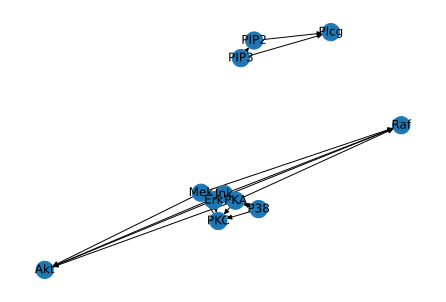

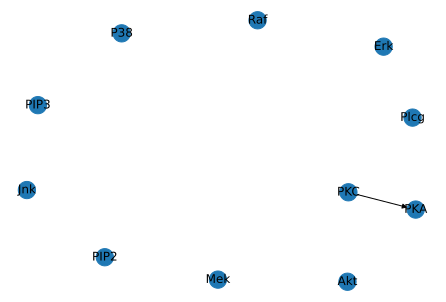

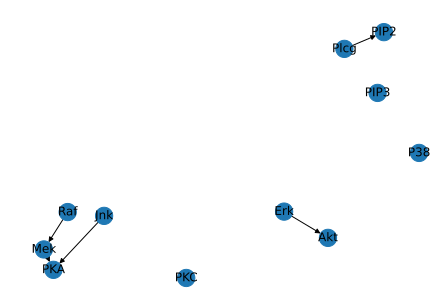

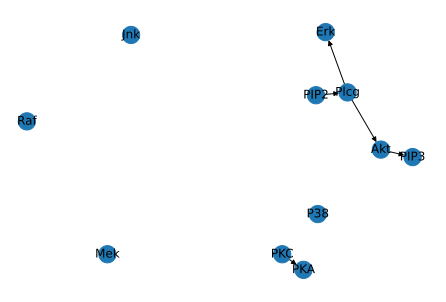

100%|█████████████████████████████████████████████| 4/4 [00:37<00:00,  9.35s/it]


{'sachs_ccdr': 0, 'sachs_lingam': 1, 'sachs_dagGNN': 2, 'sachs_notears': 3}
[0, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 0, 3, 0, 1, 0, 3, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 3, 3, 2, 0, 0, 3, 0, 0, 1, 2, 0, 0, 1, 0, 0, 3, 2, 1, 2, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 3, 0, 3, 2, 0, 0, 1, 0, 0, 2, 0, 2, 3, 0, 0, 3, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 3, 3, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 3, 0, 0, 1, 1, 1, 1, 3, 3, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 2, 1, 1, 0, 1, 0, 0, 3, 1, 1, 0, 3, 1, 0, 2, 1, 0, 2, 3, 0, 0, 0, 0, 2, 3, 0, 0, 3, 3, 3, 3, 3, 2, 2, 3, 0, 1, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 3, 0, 0, 1, 2, 0, 2, 0, 0, 2, 3, 0, 0, 0, 2, 1, 0, 3, 0, 2, 2, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 1, 0, 1, 0, 2, 3, 0, 3, 0, 2, 3, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 1, 0, 0, 0, 0, 3, 3, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 3, 1, 3, 3,

<Figure size 432x288 with 0 Axes>

In [159]:
dataset_name = 'sachs'
# replace, vals, num_disc = replace_vals(dataset_name)
# save_bool(dataset_name, replace, vals)

fnames = get_adjmats(dataset_name)
nod_names = get_nodnames(dataset_name)

learned_bns, Graphs = build_bns(fnames, nod_names, 3, [], False)

files = list(learned_bns.keys())
queries = generate_queries(dataset_name, [])
y_true = true_probs(dataset_name, queries)
y_models = get_prob_models(files, queries)
adjs = fix_adjmats(learned_bns, files)
df, clf, acc = multiclass(nod_names, files, queries, adjs, y_true, Graphs)

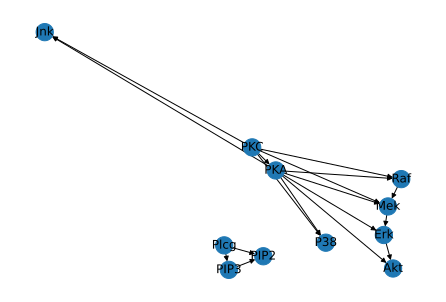

SHD
sachs_ccdr 27
sachs_lingam 16
sachs_dagGNN 16
sachs_notears 20
SID


In [164]:
true_g = get_trueg(dataset_name, nod_names)
eval_algos(dataset_name, Graphs, true_g)